# **Semantic Textual Similarity using word2vec and Clustering**
--------------------------------------------------------------------------------

## Overview
Here we have a data-set containig titles and descriptions of the products of an online retail market. Some records may do not have any description.



**Goal:** Our goal is to come up with a way to find similar products to any new unlabled product based on its title an description.

--------------------------------------------------------------------------------

## General Approach
Our general approach is to:

1.   Preprocess the texts (titles and descriptions of the products), consisting of following steps:

   *   removing common unnecessary words and stop words.
   *   removing words with only digits, which usually represent a serial number a product.
   *   removing words consisting of both numbers and english characters, which usually represent a specific model of a product.
   *   tokenizing the remaining texts.


2.   Embed the words of our vocabulary to 100 dimensional vectors using **word2vec** algorithm.
3.   Find the vectors indicating each product of our data-set by calculating the **mean** of the word vectors in the description + title.
4.   Segment the dataset to appropriate number of clusters with **Density-based spatial clustering of applications with noise (DBSCAN) clustering** algorithm.


After the segmentaion of the products we could assign a category to each cluster by analysing the members of that cluster.

To get **'N'** most similar products to a new unseen product we could measure **Cosine Silmilarity** between the vector of the description + title and all the cluster centroids. The most similar cluster will be the main category of the new product and 'N' most similar vectors of the products within that cluster to the vector of the new product will be our suggestions.

--------------------------------------------------------------------------------
## **Additional Information**

**word2vec algorithm**: The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence. As the name implies, word2vec represents each distinct word with a vector.

here are two articles about word2vec algorithm:


1.   [A Beginner's Guide to Word2Vec and Neural Word Embeddings](https://wiki.pathmind.com/word2vec)
2.   [Word2Vec Explained](https://israelg99.github.io/2017-03-23-Word2Vec-Explained/)



**DBSCAN Clusternig**: Here is a great article about [DBSCAN Algorithm and How it works.](https://www.mygreatlearning.com/blog/dbscan-algorithm/#:~:text=DBSCAN%20is%20a%20clustering%20algorithm%20that%20defines%20clusters,hyperparameters%3A%20epsilon%20and%20minPoints%20to%20arrive%20at%20clusters.)

**Cosine Similarity**: Cosine similarity is a measure of calculating distance between vectors. It is calculated as
 
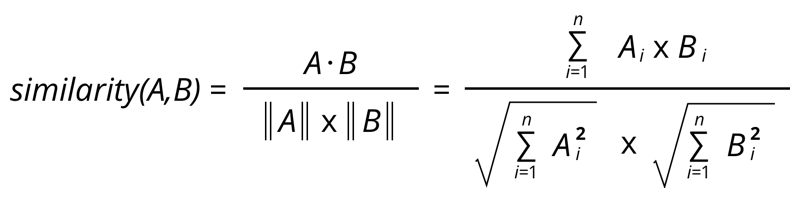


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim.models import Word2Vec
import re

### Loading the data set


In [2]:
df = pd.read_csv('/content/drive/My Drive/NLP @LOOP/products_information.csv')

In [3]:
df.drop(columns=['Unnamed: 0'],inplace=True)
df.sample(5)

,title_fa,review_description
197538,محافظ صفحه نمایش شیشه لاین 25D مناسب گوشی اپل ...,NaN
179948,انگشتر باربد ویکتوریا سنگ ماه تولد عقیق لکه برفی,خواص درمانی سنگ طبیعی معدنی عقیق لکه برفیهضم خ...
37448,کیف اداری چرم ناب K101,کیف اداری چرم کدk101تولید چرم صددرصد طبیعی گاو...
238355,پازل 1000 تکه راونزبرگر Village Harbor,NaN
185299,میوه خوری لکورد Fall2,NaN


In [4]:
# Regex pattern test for numbers and alphabet+number combinations
pattern = r'[A-Za-z]*[0-9]+[A-Za-z]*'
text = 'glow گردنبند طلا 18 عیار زنانه گالری G325'
print(re.findall(pattern,text))

['18', 'G325']


In [5]:
# Regex pattern test for numbers and alphabet+number combinations
pattern = r'[A-Za-z]*[0-9]+[A-Za-z]*'
text = 'اتو موی پروویو PW5102در ساخت اتو مو  پروویو  Prowave  PW5102  فناوری PTC NTC شده عملکرد تاثیر بسزایی فناوری PTC باعث می اتو مو کمترین بیشترین حرارت برسد  حداکثر دمای PW5102 دستگاه استفاده فناوری PTC ظرف 8 ثانیه دما می رسد فناوری NTC پخش حرارت صفحات صورت یکسان مربوط می شکل دستگاه موها کاملا یکنواخت صاف قابلیت تنظیم دما امکان کاربر فراهم می کند باتوجه نوع موی دمای اتو مو حد مناسبی تنظیم کند صفحه نمایش سیم گردان ولتاژ جهانی خصوصیات اتو مو  پروویو  Prowave  PW5102  محسوب می گفتنی سایز صفحات اتو مو متوسط ببیشتر کسانی موهای کوتاه مناسب صاف موهای بلند بهتر اتو مو صفحات پهن شود'
print((re.sub(pattern,'',text)).split())

['اتو', 'موی', 'پروویو', 'در', 'ساخت', 'اتو', 'مو', 'پروویو', 'Prowave', 'فناوری', 'PTC', 'NTC', 'شده', 'عملکرد', 'تاثیر', 'بسزایی', 'فناوری', 'PTC', 'باعث', 'می', 'اتو', 'مو', 'کمترین', 'بیشترین', 'حرارت', 'برسد', 'حداکثر', 'دمای', 'دستگاه', 'استفاده', 'فناوری', 'PTC', 'ظرف', 'ثانیه', 'دما', 'می', 'رسد', 'فناوری', 'NTC', 'پخش', 'حرارت', 'صفحات', 'صورت', 'یکسان', 'مربوط', 'می', 'شکل', 'دستگاه', 'موها', 'کاملا', 'یکنواخت', 'صاف', 'قابلیت', 'تنظیم', 'دما', 'امکان', 'کاربر', 'فراهم', 'می', 'کند', 'باتوجه', 'نوع', 'موی', 'دمای', 'اتو', 'مو', 'حد', 'مناسبی', 'تنظیم', 'کند', 'صفحه', 'نمایش', 'سیم', 'گردان', 'ولتاژ', 'جهانی', 'خصوصیات', 'اتو', 'مو', 'پروویو', 'Prowave', 'محسوب', 'می', 'گفتنی', 'سایز', 'صفحات', 'اتو', 'مو', 'متوسط', 'ببیشتر', 'کسانی', 'موهای', 'کوتاه', 'مناسب', 'صاف', 'موهای', 'بلند', 'بهتر', 'اتو', 'مو', 'صفحات', 'پهن', 'شود']


### Preprocessing

In [6]:
# replacing NaNs with empty string in order to concatinate titles an descriptions
df.fillna('',inplace=True)
df['text'] = df['title_fa'] + ' ' + df['review_description']

In [7]:
df['text'].sample(5).to_frame()

,text
78817,کفش مخصوص دویدن مردانه آدیداس Adistar
45743,کابل تبدیل USBC OTG مکا MC23 طول 015 متر
158062,کتاب کتاب حمام مامانم اثر راحله عابدین نیا
295328,ساعت مچی عقربه مردانه ریتم S1414R01 ترکیب دوست...
24853,ظرف وارمر برلینگر هاوس BH1382 کمپانی هوم ایمکس...


In [8]:
def preprocess(text):
  stopwords = ['ی','می','مدل','را','از','به','که','و']
  pattern = r'[A-Za-z]*[0-9]+[A-Za-z]*'
  tokens = (re.sub(pattern,'',text)).split()
  text = [token for token in tokens if not token in stopwords]
  return(text)

In [9]:
df['tokens'] = df['text'].apply(preprocess)
tokens = df['tokens'].to_frame()

In [10]:
tokens

,tokens
0,"[ماگ, آکو, سلمان]"
1,"[کتاب, هیس, هیس, اثر, سحر, انواری]"
2,"[ساعت, مچی, عقربه, زنانه, کیمیو]"
3,"[کاور, تاپیکس, Hard, مناسب, گوشی, موبایل, سامس..."
4,"[کاور, کوسن, آکو]"
...,...
299995,"[پایه, گردان, خورشیدی, باطری, پایه, چرخشی, گرد..."
299996,"[قهوه, ایلی, Grany, Deca, مقدار, گرم]"
299997,"[شیرینی, خوری]"
299998,"[تی, شرت, یقه, گرد, مردانه, متی]"


In [11]:
# finding the maximun lentgh of tokens
len_tokens = df['tokens'].apply(lambda x:len(x))

In [12]:
max(len_tokens)

1327

### Embeding the words using **word2vec** from Gensim Library 

In [13]:
w2v = Word2Vec(df['tokens'].values,min_count=1,
                     window=3,
                     size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)

In [14]:
w2v.init_sims(replace=True)

In [15]:
words = list(w2v.wv.vocab)

testing some words! (similarity is measured by cosine similarity)

In [16]:
w2v.most_similar('موبایل')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('گوشی', 0.889575719833374),
 ('آیفون', 0.7377980947494507),
 ('تبلت', 0.7365264892578125),
 ('سامسونگ', 0.7118581533432007),
 ('Plus', 0.6874409317970276),
 ('Note', 0.6727398633956909),
 ('کاور', 0.6716111898422241),
 ('دوربین', 0.6547080278396606),
 ('نوکیا', 0.6515638828277588),
 ('دستگاهتان', 0.645830512046814)]

In [17]:
w2v.most_similar('کتاب')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('دربردارد', 0.8127429485321045),
 ('مقدمه', 0.8053098320960999),
 ('خوانید', 0.7794033288955688),
 ('مجلد', 0.7738686800003052),
 ('مولف', 0.7730684280395508),
 ('طنز', 0.771487832069397),
 ('تالیف', 0.770850419998169),
 ('داستان', 0.7706552147865295),
 ('رمانی', 0.770344614982605),
 ('پیشگفتار', 0.7679964303970337)]

not so bad!

In [18]:
# length of vectors representing each word
len(w2v.wv.get_vector('موبایل'))

100

### Calculating the vectors of each sentence (product title + description)

In [19]:
sentence_vector_average = np.zeros((300000,100))
for ind in range(len(df['tokens'].values)):
  line = df['tokens'].values[ind]
  token_num = 0
  sentence_vector = np.zeros((100,))
  for token in line:
    sentence_vector += w2v.wv.get_vector(token)
    token_num += 1
  sentence_vector_average[ind] = sentence_vector/token_num

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [20]:
sentence_vector_average_df = pd.DataFrame(sentence_vector_average)

In [21]:
sentence_vector_average_df.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
17052,0.001354,-0.034974,-0.049349,0.007385,0.029330,0.072270,-0.140406,0.008688,-0.064330,0.027098,0.058637,-0.044883,-0.042259,-0.094237,-0.051238,0.129132,0.083220,-0.161648,-0.100970,0.038713,-0.157645,-0.136270,-0.008798,0.118248,0.084805,0.093804,-0.084492,-0.055005,0.096100,-0.024064,-0.002268,-0.084866,0.023673,0.003078,0.042996,-0.081009,-0.056700,0.075788,0.079564,0.022203,...,-0.088735,0.121804,-0.094988,-0.007872,0.004351,0.117854,0.046690,-0.013932,0.014750,-0.033441,-0.037982,-0.137744,0.153056,-0.128054,-0.200010,0.074072,0.023010,0.027236,0.009502,-0.180730,0.088115,0.026969,-0.113410,-0.009985,0.049214,0.006425,0.067991,0.026218,0.054131,-0.091073,0.038304,0.052086,-0.082504,0.074842,-0.111054,-0.044794,0.066220,0.069732,0.054623,-0.213834
2064,0.072623,0.063212,-0.124776,-0.031671,0.043503,-0.013504,0.021689,-0.009991,-0.001970,0.059956,0.053281,-0.014229,-0.039531,-0.058972,-0.047210,-0.022496,-0.023004,-0.000525,0.025863,0.106193,-0.013692,-0.019338,-0.004079,0.017014,0.084591,0.039910,-0.010639,-0.005972,0.086079,0.050216,0.016009,-0.032434,0.033536,-0.015249,0.068578,-0.029652,0.013557,0.011813,-0.001654,0.071146,...,0.039729,0.031601,-0.032086,-0.003642,-0.079578,-0.036387,0.024465,0.001311,0.017743,0.026056,-0.053625,-0.073288,0.007138,-0.041554,-0.099565,-0.014979,-0.041777,-0.045367,0.028726,-0.001850,0.051540,-0.046588,0.024405,-0.026294,-0.068693,-0.020255,-0.009198,-0.053370,0.088200,0.023983,0.052045,0.058232,0.032458,-0.045653,-0.063387,-0.024738,0.030597,0.052038,-0.008475,-0.111256
200160,0.190586,-0.025834,0.057073,-0.011286,0.078555,-0.103344,0.054163,0.018212,-0.035937,-0.050975,0.080864,-0.049154,-0.039883,0.021897,0.095017,-0.062648,-0.021991,-0.021651,-0.015044,-0.075611,-0.010620,-0.050383,0.069665,0.033541,0.070938,-0.010517,0.025357,0.043127,-0.011760,0.057876,-0.023802,0.066005,0.050648,0.129585,-0.042460,-0.058209,-0.102956,0.066720,-0.002519,0.081088,...,-0.003093,0.310469,-0.004054,0.082877,-0.148109,-0.058822,0.061603,-0.000634,0.113613,0.018910,-0.020668,0.070571,-0.110027,0.061039,-0.039206,0.001466,-0.042920,-0.044790,0.060204,-0.041022,0.008067,-0.136979,-0.037059,-0.037757,-0.080256,0.030140,0.079651,0.133992,-0.000802,0.068809,-0.025486,0.051041,-0.015034,-0.066233,-0.045644,-0.059939,0.114614,0.019891,-0.100062,-0.141203
68477,0.045997,0.024929,0.001098,-0.073512,-0.005393,0.095450,0.000436,-0.009985,0.003656,0.027587,0.078108,-0.006354,-0.031774,0.009192,-0.026098,0.096497,0.075956,-0.160362,-0.067815,0.027835,-0.099524,-0.034171,-0.083511,0.067940,0.022027,0.095090,-0.108298,-0.027273,-0.065491,-0.055806,0.005201,-0.038967,-0.137846,-0.050603,0.099258,-0.022909,-0.099636,0.026026,0.071052,-0.038945,...,0.051365,0.001076,0.002607,0.081431,-0.089972,0.029756,0.011348,-0.049492,-0.056312,-0.032143,0.095713,-0.044015,0.028354,-0.120266,-0.140603,0.078959,-0.083511,0.082294,0.016624,-0.093531,0.004516,-0.030724,-0.069841,-0.026238,-0.051539,0.010011,-0.063124,0.027844,0.098622,-0.163863,0.042790,0.115840,-0.083909,0.040643,0.009560,-0.025147,0.100334,0.088710,-0.033812,-0.242042
110627,0.037676,0.065775,-0.043067,-0.010029,-0.057898,-0.002530,0.025175,0.030751,-0.005452,0.044247,-0.004764,-0.065133,-0.227653,-0.110907,-0.053742,-0.023327,0.046006,-0.011200,0.039504,0.052637,0.131806,-0.061173,-0.077445,-0.003658,0.019712,-0.021554,-0.015145,-0.051365,0.048758,-0.102291,-0.025796,-0.042368,-0.000458,-0.100008,-0.045984,-0.026594,-0.052157,-0.039501,-0.066982,0.127352,...,-0.040974,-0.000435,0.013433,-0.062745,-0.041664,-0.043153,-0.088813,-0.134437,0.035040,-0.020333,0.046890,-0.081396,-0.119619,-0.001071,0.046314,0.001929,0.061719,0.005986,0.024906,0.014915,-0.101987,-0.015819,0.068719,0.061572,-0.026761,-0.119777,0.085220,-0.072270,0.042202,0.05

In [22]:
sentence_vector_average_df.isna().sum()

0     21
1     21
2     21
3     21
4     21
      ..
95    21
96    21
97    21
98    21
99    21
Length: 100, dtype: int64

There are 21 nan examples after calculating the sum vector of examples

These can be dropped.

### segmenting the products using sentence vectors wit Clustering

In [23]:
from sklearn.cluster import DBSCAN,KMeans

In [24]:
sentence_vector_average_df.shape

(300000, 100)

Now we Cluster the word vectors using Density-based spatial clustering of applications with noise (DBSCAN) clustering method

**Note:** Clustering the whole 300000 examples required a lot of ram which resulted in crashing the session, so i just run the algorithm on a sample of 50000 examples for tehsake of representation.

In [46]:
#DBSCAN clustering algorithm
sampled_data = sentence_vector_average_df.sample(50000).dropna().values

dbscan = DBSCAN(eps=0.1, min_samples=110, metric='cosine')
dbscan.fit(sampled_data)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='cosine',
       metric_params=None, min_samples=110, n_jobs=None, p=None)

In [47]:
# label -1 shows noise data
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20])

We got 20 clusters that we could use each represeting a product category

In [50]:
sampled_data = pd.DataFrame(sampled_data)

In [52]:
sampled_data['label'] = dbscan.labels_

In [53]:
sampled_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,label
0,0.104329,0.004700,0.008771,-0.056472,0.107413,-0.049986,0.063415,-0.071258,-0.051397,0.053155,0.039382,-0.003380,-0.031782,0.027083,0.035015,0.021713,-0.072399,0.078192,-0.005376,0.015363,-0.073590,0.032974,0.159061,-0.074763,-0.002360,0.116180,0.012628,-0.001825,-0.064436,0.132253,0.002586,-0.118603,0.047178,0.023632,0.063951,-0.079655,0.027661,0.099638,0.017809,-0.027758,...,0.190002,-0.110137,0.102852,-0.078585,0.035801,-0.062685,-0.039001,0.033498,-0.069851,-0.179175,-0.018267,-0.021764,0.008295,-0.155267,-0.044193,0.049483,0.041023,0.023430,-0.088569,0.072888,-0.032242,0.051952,0.033436,0.114631,0.001541,-0.004320,-0.041464,0.054402,0.090195,0.023408,0.036589,0.139416,-0.076188,-0.091882,0.002008,0.180534,0.084026,-0.089298,-0.040386,0
1,0.040908,0.066303,-0.018144,-0.108551,-0.012974,0.034679,0.095842,-0.040233,-0.110804,-0.038555,0.065725,-0.086871,0.017319,0.083433,0.001036,-0.009493,0.087523,-0.111428,0.003380,0.038599,-0.003976,-0.038995,-0.016871,0.013472,0.016332,0.064629,0.008395,0.023727,-0.101884,-0.031480,-0.066712,-0.094157,-0.141443,-0.095461,0.000208,0.036343,-0.022869,-0.080716,-0.041594,0.044373,...,0.052794,0.099364,0.070191,-0.120508,-0.086586,0.050022,-0.005083,-0.015210,-0.015906,0.037434,0.029903,-0.034101,-0.025446,0.047895,0.003980,0.011910,0.055740,-0.010118,-0.024989,-0.085246,-0.181209,0.075878,-0.027060,-0.040791,0.060106,-0.068787,-0.105652,0.093088,-0.003742,0.049143,0.105564,0.033579,-0.087006,-0.009284,0.074208,0.073912,0.012430,-0.103870,-0.107352,1
2,0.100434,0.028003,0.034354,-0.049232,0.009606,-0.057760,-0.002280,-0.078972,-0.019609,0.061580,-0.026178,0.030550,-0.007076,0.060107,0.010681,0.020464,-0.007709,0.001371,-0.020436,0.085592,-0.053642,0.032191,0.089870,-0.057141,0.013429,0.082751,0.005123,0.006735,-0.101353,0.116882,-0.040743,-0.081472,-0.014139,-0.062990,0.072095,-0.002753,0.054406,0.002804,0.005583,0.024076,...,0.108567,-0.046210,0.074468,-0.114307,-0.025746,-0.008466,-0.032797,0.056480,-0.048666,-0.074965,0.010924,-0.057781,0.048056,-0.095289,-0.012094,0.025008,0.083175,-0.004451,-0.027686,-0.003645,-0.052562,0.071217,-0.001122,0.035899,0.049313,-0.042387,-0.029477,0.083396,0.051208,0.019980,0.058136,0.084095,-0.102721,-0.102536,0.040000,0.151290,0.028457,-0.071669,-0.033092,0
3,-0.099721,0.005617,-0.114904,-0.106221,0.015936,0.011114,0.055873,-0.029234,-0.018206,-0.017140,0.115994,-0.047927,-0.047880,-0.074023,0.031349,-0.075167,0.063695,0.086206,0.020317,0.020224,0.009930,-0.032244,0.074507,0.012240,0.000332,0.077725,-0.063123,0.025585,0.045884,-0.054433,0.116606,-0.026206,0.027842,0.014174,-0.057551,-0.117593,-0.005068,0.008137,0.001784,-0.010760,...,0.071454,-0.006612,-0.076912,-0.040735,0.089481,0.093265,-0.017386,0.071774,0.067275,0.121003,0.043104,0.095455,-0.087733,-0.035375,-0.061092,-0.002220,-0.191240,0.060668,-0.006380,-0.012027,-0.091281,0.056638,0.061428,-0.009382,-0.018966,0.058939,0.046978,-0.008546,-0.007546,-0.044145,0.136885,-0.049080,0.035546,-0.073303,-0.051151,-0.082857,0.067189,0.120173,-0.032508,14
4,0.039807,-0.001056,-0.050158,-0.035802,0.001427,0.004875,-0.079932,0.064207,-0.046111,0.133473,0.012689,0.001571,0.081494,-0.084567,-0.047840,0.008875,-0.040446,-0.013158,-0.040508,0.001083,-0.046697,-0.093299,-0.046108,0.033318,0.060529,0.018802,-0.067462,-0.003988,0.077370,0.059822,0.026129,-0.028093,0.037076,-0.047139,0.034795,0.009712,-0.004450,-0.009719,-0.009482,0.112084,...,0.070923,-0.048247,-0.025827,0.000410,-0.037971,-0.051787,-0.034733,0.042055,-0.009264,-0.023259,-0.082038,0.045263,-0.116861,-0.064747,0.005318,0.021944,0.044843,0.033129,-0.032188,0.067251,-0.042078,-0.026966,-0.006448,-0.019664,0.047014,-0.029997,-0.087538,0.115637,-0.015439,0.099352,0.042434,0.060196,-0.080725,-0.005297,-0.033026,0.060241,0

----------------------------------------------

Lets make a Dictionary to store the mean vector of each category:


In [55]:
# keys -> cluster_number
# values -> mean vector of that cluster

category_vectors = {i:sampled_data[sampled_data['label'] == i].iloc[:,0:100].mean() for i in range(21)}

Now Lets observe what category each cluster represents

In [70]:
w2v.similar_by_vector(category_vectors[1].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('آنتا', 0.8282709121704102),
 ('کفش', 0.8101304173469543),
 ('اسکچرز', 0.8098382949829102),
 ('لتون', 0.7993772625923157),
 ('GOwalk', 0.7919614911079407),
 ('دویدن', 0.791439950466156),
 ('جوما', 0.7885371446609497),
 ('MIRACLE', 0.7884770631790161),
 ('Stan', 0.7880978584289551),
 ('Adipure', 0.7869611978530884)]

Cluster 1 is mostly related to **shoes and sneakers**

In [71]:
w2v.similar_by_vector(category_vectors[2].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('پولوشرت', 0.8204652667045593),
 ('لگینگ', 0.8073954582214355),
 ('سوییشرت', 0.781952977180481),
 ('شومیز', 0.7767382860183716),
 ('آستین', 0.7760021686553955),
 ('زنانه', 0.7684909105300903),
 ('شلوارهای', 0.7680611610412598),
 ('استین', 0.763431191444397),
 ('گارودی', 0.7625313401222229),
 ('یوپیم', 0.7618343830108643)]

Cluster 1 is mostly related to **shirts and T-shirts**

In [73]:
w2v.similar_by_vector(category_vectors[3].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('عقیق', 0.9040893316268921),
 ('سنگ', 0.9008742570877075),
 ('جاسپر', 0.872017502784729),
 ('لاجورد', 0.8685940504074097),
 ('یمنی', 0.8574920892715454),
 ('حدید', 0.8561422824859619),
 ('توپاز', 0.852693498134613),
 ('جید', 0.8464436531066895),
 ('زبرجد', 0.8456164598464966),
 ('یشم', 0.8388755917549133)]

Cluster 3 is mostly related to **Jewelries**

In [74]:
w2v.similar_by_vector(category_vectors[4].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('مچی', 0.9377319812774658),
 ('عقربه', 0.9000678062438965),
 ('رومانسون', 0.8393601179122925),
 ('تیسوت', 0.8369371891021729),
 ('کاندینو', 0.8204541206359863),
 ('رادو', 0.80576092004776),
 ('وستار', 0.7946540117263794),
 ('ارنشا', 0.7935017943382263),
 ('ساعت', 0.7934136390686035),
 ('کورنوگراف', 0.7931046485900879)]

Cluster 4 is mostly related to **watches**

In [81]:
w2v.similar_by_vector(category_vectors[5].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('آفتابی', 0.9218425750732422),
 ('عینک', 0.8751509785652161),
 ('گس', 0.8617125749588013),
 ('لوزا', 0.8555668592453003),
 ('Guess', 0.8477016687393188),
 ('ویفرر', 0.8250023126602173),
 ('خلبانی', 0.8060670495033264),
 ('گانت', 0.7998471260070801),
 ('Lozza', 0.7979069352149963),
 ('مارسیانو', 0.7897413969039917)]

Cluster 5 is mostly related to **glasses**

In [79]:
w2v.similar_by_vector(category_vectors[7].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('دستبافت', 0.8946883678436279),
 ('فرش', 0.8334887027740479),
 ('دستباف', 0.8166359066963196),
 ('فرشی', 0.8125796914100647),
 ('قالیچه', 0.7949178218841553),
 ('ذرع', 0.7776476740837097),
 ('وینتیج', 0.7720241546630859),
 ('کلاژ', 0.7603014707565308),
 ('گلیم', 0.753655731678009),
 ('کلاژفرش', 0.7505193948745728)]

Cluster 7 is mostly related to **Carpets and rugs**

In [84]:
w2v.similar_by_vector(category_vectors[8].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('دربارهی', 0.9136397242546082),
 ('بازنویسی', 0.907249927520752),
 ('دیباچه', 0.8991974592208862),
 ('تئاتری', 0.8953952789306641),
 ('آموزگار', 0.8933660984039307),
 ('ژرفای', 0.8933285474777222),
 ('تفحص', 0.8926522135734558),
 ('شرحی', 0.8919925689697266),
 ('رهگذر', 0.8880715370178223),
 ('صوفیه', 0.8860899209976196)]

it seems that Cluster 8 is mostly related to **literature** 

In [86]:
w2v.similar_by_vector(category_vectors[9].values,20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('ماگ', 0.9034676551818848),
 ('لومانا', 0.8311771154403687),
 ('استارباکس', 0.7998494505882263),
 ('ماگستان', 0.7998427748680115),
 ('سپاهانی', 0.7942887544631958),
 ('pm_', 0.7738790512084961),
 ('Mickep', 0.7631633281707764),
 ('ریجینال', 0.7582796812057495),
 ('بزگتری', 0.7497599124908447),
 ('Sarah', 0.742853045463562),
 ('ماگهای', 0.7383413314819336),
 ('مسافرتیمینی', 0.7361195087432861),
 ('رنگارشاپ', 0.7297502756118774),
 ('Prıncess', 0.7293574213981628),
 ('انارچاپ', 0.7258710861206055),
 ('ماگی', 0.7156023383140564),
 ('سینایا', 0.6999820470809937),
 ('Capricorn', 0.6984260678291321),
 ('فالومی', 0.6982779502868652),
 ('bookD', 0.697514533996582)]

it seems that Cluster 8 is mostly related to **Mugs** and so on ...

we should do this observations for all 20 clusters

Finally to predict a new product's category:

* first we should create a dictionary, mapping all the clusters to its observed category as above.
* then we should get the new products sentence vectoor by averaging its title's word vectors
* and at last finding the most similar category vector to the new products sentence vector

In [ ]:
category_cluster_map = {1:'shoes', 2:'clothes', 3:'jewelries',4: 'watches' , 5:'glasses'}

def predict_category(product_title):
  tokens = preprocess(product_title)

  sentence_vector = np.zeros(100,)
  token_num = 0
  for token in tokens:
    if token in w2v.wv.vocab:
      vector = w2v.wv[token]
      token_num += 1
      sentence_vector += vector
    else:
      continue
  
  sentence_vector = sentence_vector/token_num    # averaging over words of the sentence

  most_similar_vector = None
  most_similar_cluster = None
  max_similarity = 0
  for cluster in category_cluster_map.keys():
    cluster_vector = category_vectors[cluster]
    if w2v.wv.similarity(cluster_vector , sentence_vector) > max_similarity:
      max_similarity = w2v.wv.similarity(cluster_vector , sentence_vector)
      most_similar_cluster = cluster
      most_similar_vector = cluster_vector
  
  return(category_cluster_map[most_similar_cluster])



